# Importing packages

In [61]:
from sdv.evaluation import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import shap
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from keras.layers import Input, Dense
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from numpy.linalg import norm

In [62]:
# Setting up data
data = pd.read_csv("data/Mango_nir_vis.csv")
full_spec = data.iloc[:, 8:].copy()


## Helper functions

In [225]:
def heatmap_specs(dfs, names, plot_name=None, figsize=(10,15)):
    """
    Plots heatmaps of all spectral samples
    """
    fig, ax = plt.subplots(len(dfs), 1, figsize=figsize)
    
    for i, df in enumerate(dfs):
        sns.heatmap(df, ax=ax[i])
        ax[i].set_title(names[i])
    if plot_name:    
        plt.savefig(f"{plot_name}")
    plt.show()

def calculate_univariate_stats(df):
    """
    Function that calculates univariate stats of the dataframe
    """
    df_stats = df.describe().iloc[1:, :]
    df_stats.loc["skew", :] = df.skew()
    df_stats.loc["kurtosis", :] = df.kurt()
    return df_stats
    
def lineplot_specs(dfs, names, plot_name=None, figsize=(10,15)):
    """
    Plots all spectral samples in dataset
    """
    fig, ax = plt.subplots(len(dfs), 1, figsize=(10,15))

    for idx, df in enumerate(dfs):
        df.T.plot(legend=False, ax=ax[idx])
        ax[idx].set_title(names[idx])
    if plot_name:    
        plt.savefig(f"{plot_name}")
    plt.show()
    
def plot_sample(df, sample, plot_name=None):
    """
    Plots a line plot of a sample
    """
    plt.plot(df.T.index.astype(float), df.iloc[sample])
    if plot_name:    
        plt.savefig(f"{plot_name}")
    plt.show()

def plot_multiple_samples(dfs, samples, names, y_limit=[-0.9, 0.5], plot_name=None):
    """
    Plots multiple samples in individual subplots
    """
    fig, axes = plt.subplots(len(samples), len(dfs))

    for ax, name in zip(axes[0], names):
        ax.set_title(name)

    for idx1, df in enumerate(dfs):
        for idx2, sample in enumerate(samples):
            axes[idx2, idx1].plot(df.T.index.astype(float), df.iloc[sample])
            axes[idx2, idx1].set_ylim(y_limit)

    plt.tight_layout()
    plt.show()

def create_nir_with_response(df):
    """
    Function that selects columns that have complete spectra, and adds 'DM' (dry matter) 
    as target. It then returns the dataframe with rows permuted.
    """
    nir = df.loc[:, '699':'1032'].copy()
    #nir = nir.copy()
    nir["DM"] = df["DM"].copy()
    return nir.reindex(np.random.RandomState(seed=1).permutation(nir.index))

# KL-divergence formula
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0)) 

# Cosine similarity
def cos_similarity(p,q):
    return 1 - distance.cosine(p, q)

def cosine_similarity(p, q):
    return np.dot(p, q)/(norm(p)*norm(q))


# Transforming columns
scaler = MinMaxScaler(feature_range=(-1, 1))
def transform_cols(df):
    df_2 = scaler.fit_transform(df)
    df_2 = pd.DataFrame(df_2)
    return df_2

def plot_scatter(data1, data2, data3, title, subtitle1, subtitle2, subtitle3):
    fig, ax = plt.subplots(2,2, figsize=(12, 8))
    
    x_min, x_max = min(data1[:, 0].min(), data2[:, 0].min(), data3[:, 0].min())-3, max(data1[:, 0].max(), data2[:, 0].max(), data3[:, 0].max())+3
    y_min, y_max = min(data1[:, 1].min(), data2[:, 1].min(), data3[:, 1].min())-3, max(data1[:, 1].max(), data2[:, 1].max(), data3[:, 1].max())+3
    
    ax[0, 0].scatter(data1[:, 0], data1[:, 1])
    ax[0, 0].set_title(subtitle1)
    ax[0, 0].set_xlim(x_min, x_max)
    ax[0, 0].set_ylim(y_min, y_max)
    
    ax[0, 1].scatter(data2[:, 0], data2[:, 1])
    ax[0, 1].set_title(subtitle2)
    ax[0, 1].set_xlim(x_min, x_max)
    ax[0, 1].set_ylim(y_min, y_max)
    
    ax[1, 0].scatter(data1[:, 0], data1[:, 1])
    ax[1, 0].set_title(subtitle1)
    ax[1, 0].set_xlim(x_min, x_max)
    ax[1, 0].set_ylim(y_min, y_max)
    
    ax[1, 1].scatter(data3[:, 0], data3[:, 1])
    ax[1, 1].set_title(subtitle3)
    ax[1, 1].set_xlim(x_min, x_max)
    ax[1, 1].set_ylim(y_min, y_max)
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


In [64]:
# Setting up data
data = pd.read_csv("data/Mango_nir_vis.csv")
full_spec = data.iloc[:, 9:].copy()
nir_response = create_nir_with_response(data)
nir = nir_response.drop("DM", axis=1)
nir_dm = nir_response["DM"]

In [65]:
# Loading synthetic data
#ctgan_nir = pd.read_csv("data/ctgan_nir.csv")
#tvae_nir = pd.read_csv("data/tvae_nir.csv")
ctgan_nir_response = pd.read_csv("data/ctgan_nir_with_response.csv")
tvae_nir_response = pd.read_csv("data/tvae_nir_with_response.csv")
ctgan_nir = ctgan_nir_response.drop("DM", axis=1)
tvae_nir = tvae_nir_response.drop("DM", axis=1)
ctgan_dm = ctgan_nir_response["DM"]
tvae_dm = tvae_nir_response["DM"]


In [66]:
ctgan_nir_response

,699,702,705,708,711,714,717,720,723,726,...,1008,1011,1014,1017,1020,1023,1026,1029,1032,DM
0,-0.395169,-0.370937,-0.328442,-0.672595,-0.410766,-0.363907,-0.732040,-0.648652,-0.679856,-0.606610,...,-0.389666,-0.448103,-0.307108,-0.366360,-0.413263,-0.462951,-0.346854,-0.527912,-0.468481,22.917592
1,-0.235806,0.114511,-0.407289,-0.360406,-0.289677,0.021625,-0.445674,-0.367384,-0.360403,-0.564233,...,-0.333273,-0.340616,-0.329361,-0.312470,-0.348562,-0.382672,-0.390599,-0.413058,-0.337439,22.595511
2,0.179283,0.064902,-0.207032,-0.363021,-0.378473,-0.301605,-0.351514,-0.411905,-0.471151,-0.535732,...,-0.247885,-0.250489,-0.264597,-0.315422,-0.323690,-0.331711,-0.322994,-0.360561,-0.318964,13.636169
3,-0.008406,0.359451,-0.393977,-0.166142,-0.472853,0.046175,-0.143712,-0.374399,-0.146220,-0.543739,...,-0.289863,-0.286342,-0.302238,-0.294040,-0.339860,-0.330049,-0.312242,-0.313681,-0.302432,10.959914
4,-0.338881,-0.147606,-0.437825,-0.581764,-0.696950,-0.377066,-0.438077,-0.722659,-0.527977,-0.534822,...,-0.341377,-0.360172,-0.341181,-0.380823,-0.480163,-0.397023,-0.342553,-0.435695,-0.475482,12.702366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11686,0.122830,0.084907,-0.469383,-0.250665,-0.338677,-0.412861,-0.652339,-0.504443,-0.419088,-0.551900,...,-0.309155,-0.335449,-0.335269,-0.338377,-0.350174,-0.326452,-0.339724,-0.409627,-0.326696,15.173966
11687,-0.206979,-0.266670,-0.481312,-0.329948,-0.321304,-0.356091,-0.446810,-0.611787,-0.566631,-0.619875,...,-0.271556,-0.309667,-0.322481,-0.315847,-0.335940,-0.326941,-0.333458,-0.406582,-0.334795,16.276479
11688,-0.001561,-0.152534,-0.097785,-0.253383,-0.184184,-0.172585,-0.274593,-0.405868,-0.394126,-0.337489,...,-0.284840,-0.300688,-0.308536,-0.294498,-0.333349,-0.328593,-0.324854,-0.392503,-0.318538,14.923623
11689,-0.054845,-0.129243,-0.266168,-0.553346,-0.376990,-0.344137,-0.630489,-0.444973,-0.579216,-0.557785,...,-0.312931,-0.347782,-0.308421,-0.324117,-0.289512,-0.386864,-0.378975,-0.407753,-0.333148,17.783198


In [67]:
tvae_nir_response

,699,702,705,708,711,714,717,720,723,726,...,1008,1011,1014,1017,1020,1023,1026,1029,1032,DM
0,-0.266216,-0.233085,-0.377961,-0.492530,-0.516378,-0.501174,-0.480448,-0.497591,-0.502367,-0.542018,...,-0.306637,-0.323109,-0.309691,-0.339149,-0.350517,-0.372586,-0.357270,-0.393047,-0.382344,14.144209
1,-0.071726,-0.100097,-0.161429,-0.262141,-0.273369,-0.373871,-0.369171,-0.393589,-0.442320,-0.464838,...,-0.309252,-0.305369,-0.325371,-0.331044,-0.344316,-0.346417,-0.343521,-0.382898,-0.378250,12.390040
2,-0.030068,-0.078643,-0.270781,-0.168176,-0.285335,-0.417301,-0.389569,-0.432358,-0.476023,-0.484736,...,-0.239551,-0.288321,-0.271578,-0.285647,-0.285367,-0.304818,-0.293986,-0.316207,-0.339226,18.233597
3,-0.363749,-0.284578,-0.336858,-0.449092,-0.416888,-0.456532,-0.462186,-0.497000,-0.624693,-0.525935,...,-0.293969,-0.312512,-0.328285,-0.357599,-0.331663,-0.350644,-0.389497,-0.358671,-0.378006,17.641472
4,-0.193152,-0.302251,-0.362217,-0.340148,-0.340353,-0.371694,-0.382097,-0.437650,-0.484325,-0.504946,...,-0.305115,-0.326931,-0.322858,-0.330516,-0.348998,-0.361838,-0.364233,-0.381045,-0.398460,13.911783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11686,0.112362,-0.039726,-0.031275,-0.166716,-0.048808,-0.242668,-0.236183,-0.377748,-0.442349,-0.389277,...,-0.266065,-0.306273,-0.314817,-0.301027,-0.330182,-0.332383,-0.328398,-0.363628,-0.378211,21.414462
11687,-0.523225,-0.588746,-0.536707,-0.658968,-0.542148,-0.543015,-0.566727,-0.546519,-0.596493,-0.657664,...,-0.334540,-0.251719,-0.317932,-0.320243,-0.402413,-0.372728,-0.356464,-0.349246,-0.345199,21.909475
11688,0.153394,-0.157543,-0.227087,-0.026743,-0.376961,-0.327998,-0.431880,-0.390470,-0.487631,-0.493815,...,-0.254693,-0.258880,-0.264728,-0.254501,-0.323532,-0.318156,-0.308251,-0.354718,-0.320859,19.036838
11689,-0.110304,-0.288943,-0.199120,-0.309074,-0.389410,-0.437396,-0.525341,-0.382470,-0.541825,-0.464716,...,-0.285593,-0.292527,-0.300248,-0.306329,-0.323149,-0.341079,-0.351645,-0.351398,-0.362692,16.922120


## Basic statistics

In [226]:
nir_stats = calculate_univariate_stats(nir)  #nir.describe()
ctgan_stats = calculate_univariate_stats(ctgan_nir) #ctgan_nir.describe()
tvae_stats = calculate_univariate_stats(tvae_nir) #tvae_nir.describe()
cos_scores_ctgan = []
cos_scores_tvae = []
for idx in range(nir_stats.shape[0]-1):
    cos_scores_ctgan.append(cosine_similarity(nir_stats.iloc[idx+1, :], ctgan_stats.iloc[idx+1, :]))
    cos_scores_tvae.append(cosine_similarity(nir_stats.iloc[idx+1, :], tvae_stats.iloc[idx+1, :]))

In [227]:
basic_stats_raw = pd.DataFrame(index=nir_stats.index[1:])
basic_stats_raw["CTGAN_NIR"] = cos_scores_ctgan
basic_stats_raw["TVAE_NIR"] = cos_scores_tvae


In [228]:
basic_stats_raw

,CTGAN_NIR,TVAE_NIR
std,0.986167,0.998840
min,0.999995,0.999880
25%,0.998402,0.999977
50%,0.998050,0.999982
75%,0.997646,0.999971
max,1.000000,0.999998
skew,0.931373,0.967953
kurtosis,0.832141,0.949244


In [71]:
dm_stats = nir_response["DM"].describe()[1:]
ctgan_dm_stats = ctgan_nir_response["DM"].describe()[1:]
tvae_dm_stats = tvae_nir_response["DM"].describe()[1:]
cos_scores_ctgan_dm = []
cos_scores_tvae_dm = []
for idx, _ in enumerate(dm_stats):
    cos_scores_ctgan_dm.append(cosine_similarity(dm_stats[idx], ctgan_dm_stats[idx]))
    cos_scores_tvae_dm.append(cosine_similarity(dm_stats[idx], tvae_dm_stats[idx]))

In [72]:
tvae_dm_stats

mean    16.558649
std      2.609524
min      9.496897
25%     14.432283
50%     16.713297
75%     18.255060
max     24.577150
Name: DM, dtype: float64

In [73]:
dm_stats

mean    16.282835
std      2.459531
min      9.464606
25%     14.332756
50%     16.301700
75%     18.112985
max     24.577150
Name: DM, dtype: float64

# Plotting synthetic data against real data

In [74]:
ctgan_nir = ctgan_nir_response.iloc[:, :-1]
tvae_nir = tvae_nir_response.iloc[:, :-1]
nir = nir_response.iloc[:, :-1]


### Visual inspection

In [75]:
ctgan_nir_fig = ctgan_nir.T.plot(legend=False).get_figure()
plt.savefig("figs/ctgan_nir_fig.png")

In [76]:
tvae_nir_fig = tvae_nir.T.plot(legend=False).get_figure()
plt.savefig("figs/tvae_nir_fig.png")

In [77]:
nir_fig = nir.T.plot(legend=False).get_figure()
plt.savefig("figs/nir_fig.png")

In [78]:
print(f"max wavelength value of synthetic NIR spectra generated by CTGAN: {ctgan_nir.max().max()}")
print(f"max wavelength value of synthetic NIR spectra generated by TVAE: {tvae_nir.max().max()}")
print(f"max wavelength value of original NIR spectra: {nir.max().max()}")

max wavelength value of synthetic NIR spectra generated by CTGAN: 0.4772278
max wavelength value of synthetic NIR spectra generated by TVAE: 0.4772278
max wavelength value of original NIR spectra: 0.4772278


In [79]:
print(f"min wavelength value of synthetic NIR spectra generated by CTGAN: {ctgan_nir.min().min()}")
print(f"min wavelength value of synthetic NIR spectra generated by TVAE: {tvae_nir.min().min()}")
print(f"min wavelength value of original NIR spectra: {nir.min().min()}")

min wavelength value of synthetic NIR spectra generated by CTGAN: -0.7690067
min wavelength value of synthetic NIR spectra generated by TVAE: -0.7650639
min wavelength value of original NIR spectra: -0.7690067


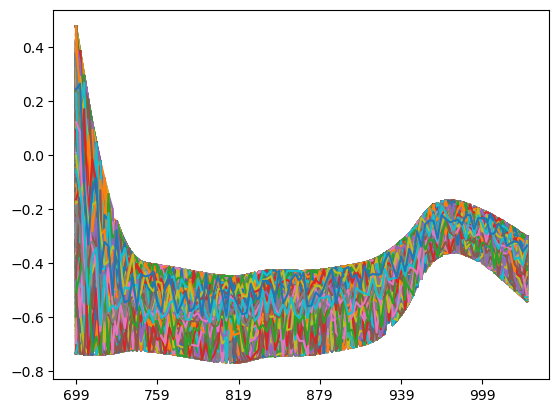

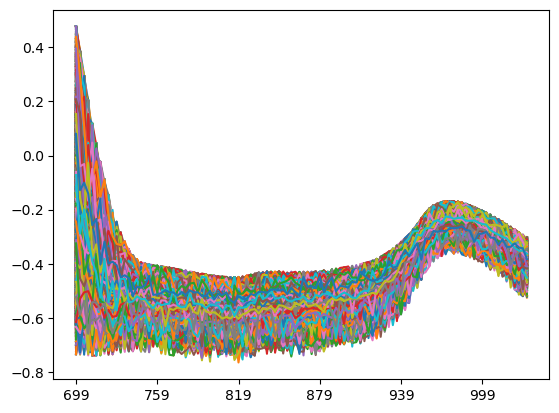

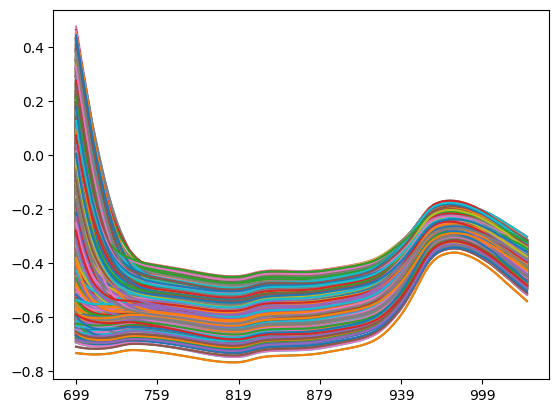

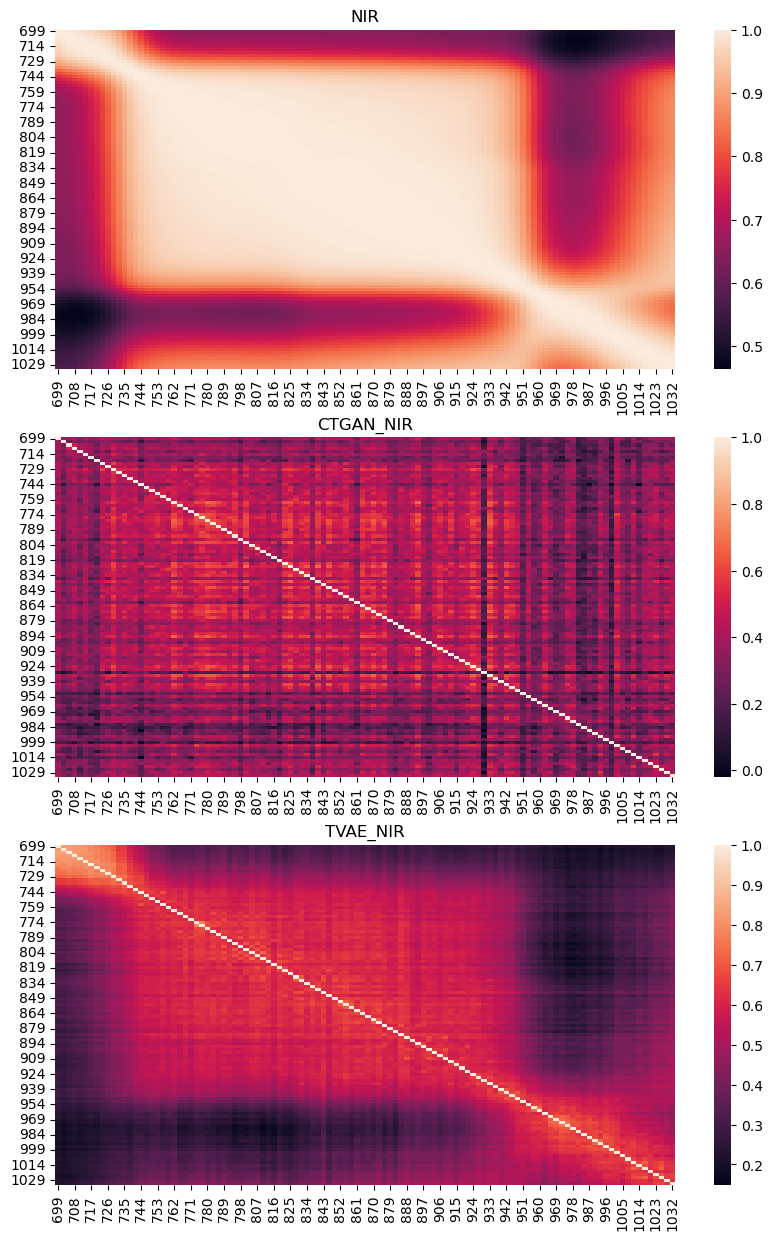

In [80]:
heatmap_specs([nir.corr(), ctgan_nir.corr(), tvae_nir.corr()], ["NIR", "CTGAN_NIR", "TVAE_NIR"])

In [81]:
nir.corr()-ctgan_nir.corr()

,699,702,705,708,711,714,717,720,723,726,...,1005,1008,1011,1014,1017,1020,1023,1026,1029,1032
699,0.000000,0.628412,0.630987,0.566910,0.677415,0.584726,0.638336,0.617945,0.500845,0.527041,...,0.162263,0.285289,0.108973,0.321916,0.231229,0.164190,0.140673,0.204157,0.179200,0.176469
702,0.628412,0.000000,0.712618,0.669834,0.716858,0.670536,0.716274,0.656754,0.653448,0.605043,...,0.299172,0.342846,0.202516,0.236616,0.316897,0.310058,0.269116,0.275854,0.275350,0.230698
705,0.630987,0.712618,0.000000,0.497233,0.591660,0.597623,0.634688,0.719258,0.572200,0.622184,...,0.331521,0.341185,0.268033,0.392655,0.238964,0.205013,0.231705,0.375410,0.244044,0.321767
708,0.566910,0.669834,0.497233,0.000000,0.606501,0.583213,0.600362,0.623612,0.546130,0.560513,...,0.219172,0.264319,0.206301,0.309878,0.221622,0.214528,0.189989,0.255028,0.196380,0.203001
711,0.677415,0.716858,0.591660,0.606501,0.000000,0.611067,0.612817,0.760012,0.627699,0.745111,...,0.349472,0.367820,0.389894,0.360463,0.247355,0.237969,0.334110,0.434351,0.383032,0.328131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.164190,0.310058,0.205013,0.214528,0.237969,0.251236,0.373337,0.399914,0.254113,0.285395,...,0.607262,0.711517,0.601635,0.726071,0.585066,0.000000,0.543651,0.709031,0.587785,0.626891
1023,0.140673,0.269116,0.231705,0.189989,0.334110,0.215609,0.282666,0.378439,0.260585,0.236344,...,0.630492,0.591253,0.423372,0.662482,0.556835,0.543651,0.000000,0.528601,0.545781,0.562512
1026,0.204157,0.275854,0.375410,0.255028,0.434351,0.258284,0.373740,0.392795,0.414982,0.351565,...,0.665951,0.655746,0.648307,0.712098,0.717737,0.709031,0.528601,0.000000,0.586679,0.619436
1029,0.179200,0.275350,0.244044,0.196380,0.383032,0.287202,0.341798,0.401984,0.297928,0.246817,...,0.641524,0.602172,0.511526,0.698083,0.659754,0.587785,0.545781,0.586679,0.000000,0.582490


In [82]:
corr_diff_tvae = nir.corr()-tvae_nir.corr()
corr_diff_tvae = corr_diff_tvae.abs()
rows, cols = np.triu_indices_from(corr_diff_tvae, k=1)
#unique_corr_pairs = [(corr_diff_tvae.index[row], corr_diff_tvae.columns[col], corr_diff_tvae.iloc[row, col])
                        #for row, col in zip(rows, cols)]
    
unique_corr_tvae = np.array([corr_diff_tvae.iloc[row, col] for row, col in zip(rows, cols)])

In [83]:
print(np.mean(unique_corr_tvae))
print(np.min(unique_corr_tvae))
print(np.max(unique_corr_tvae))

0.3841816859553953
0.15425093496930253
0.5332278454503148


In [84]:
corr_diff_ctgan = nir.corr()-ctgan_nir.corr()
corr_diff_ctgan = corr_diff_ctgan.abs()
rows, cols = np.triu_indices_from(corr_diff_ctgan, k=1)
#unique_corr_pairs = [(corr_diff_tvae.index[row], corr_diff_tvae.columns[col], corr_diff_tvae.iloc[row, col])
                        #for row, col in zip(rows, cols)]
    
unique_corr_ctgan = np.array([corr_diff_ctgan.iloc[row, col] for row, col in zip(rows, cols)])

In [85]:
np.mean(unique_corr_ctgan)
np.min(unique_corr_ctgan)
print(np.max(unique_corr_ctgan))

0.9357320373206647


In [86]:
ctgan_corr = ctgan_nir.corr()
rows, cols = np.triu_indices_from(ctgan_corr, k=1)
corr_ctgan = np.array([ctgan_corr.iloc[row, col] for row, col in zip(rows, cols)])
corr_ctgan

array([0.36997986, 0.36351378, 0.42228244, ..., 0.41240053, 0.37775811,
       0.41662036])

In [87]:
tvae_corr = tvae_nir.corr()
rows, cols = np.triu_indices_from(tvae_corr, k=1)
corr_tvae = np.array([tvae_corr.iloc[row, col] for row, col in zip(rows, cols)])
corr_tvae

array([0.82818691, 0.84024962, 0.82520925, ..., 0.64208385, 0.66070295,
       0.63199653])

In [88]:
nir_corr = nir.corr()
rows, cols = np.triu_indices_from(nir_corr, k=1)
corr_nir = np.array([nir_corr.iloc[row, col] for row, col in zip(rows, cols)])
corr_nir

array([0.99839147, 0.99450055, 0.9891924 , ..., 0.99907946, 0.9971942 ,
       0.99911039])

In [89]:
cos_tvae = cosine_similarity(corr_nir, corr_tvae)
cos_ctgan = cosine_similarity(corr_nir, corr_ctgan)

In [90]:
spec_corr = pd.DataFrame(columns=["CTGAN_NIR", "TVAE_NIR"], index=["Mean", "Min", "Max", "Cos sim"])
spec_corr["CTGAN_NIR"] = [np.mean(unique_corr_ctgan), np.min(unique_corr_ctgan), np.max(unique_corr_ctgan), cos_ctgan]
spec_corr["TVAE_NIR"] = [np.mean(unique_corr_tvae), np.min(unique_corr_tvae), np.max(unique_corr_tvae), cos_tvae]


In [91]:
spec_corr

,CTGAN_NIR,TVAE_NIR
Mean,0.471212,0.384182
Min,0.066943,0.154251
Max,0.935732,0.533228
Cos sim,0.967834,0.989142


In [92]:
dfs = [nir, ctgan_nir, tvae_nir]
names = ["NIR", "CTGAN_NIR", "TVAE_NIR"]
fig, ax = plt.subplots(len(dfs), 1, figsize=(10,15))

for idx, df in enumerate(dfs):
    df.T.plot(legend=False, ax=ax[idx])
    ax[idx].set_title(names[idx])

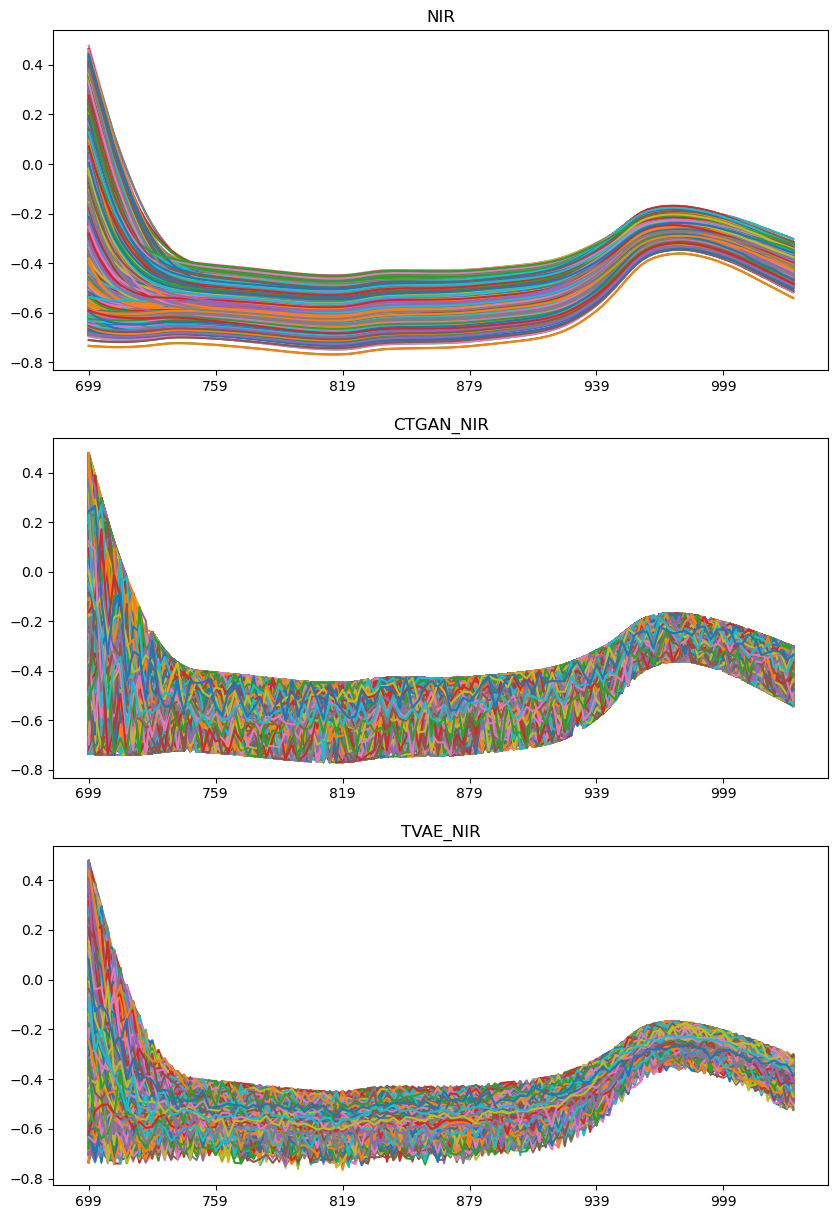

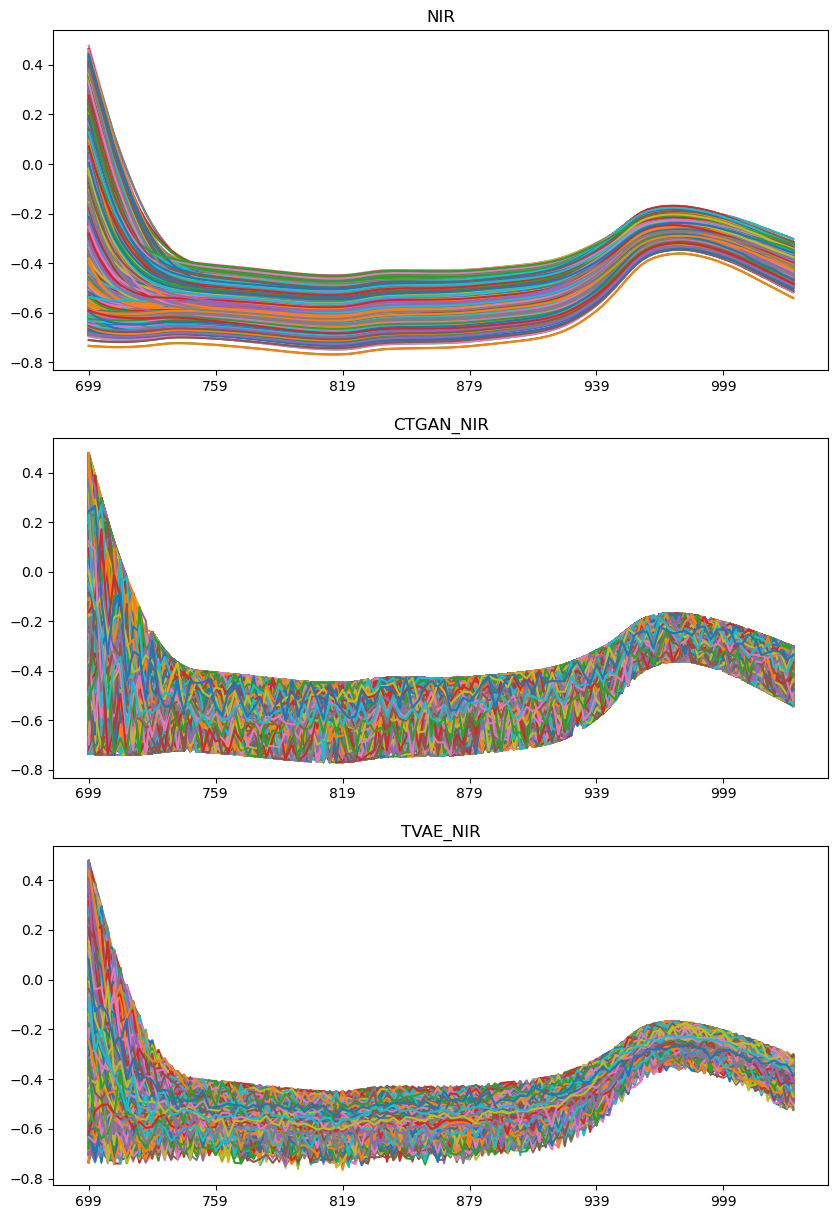

In [93]:
lineplot_specs([nir, ctgan_nir, tvae_nir], ["NIR", "CTGAN_NIR", "TVAE_NIR"])

In [148]:
plot_multiple_samples([nir, ctgan_nir, tvae_nir], list(range(10, 51, 10)), ["NIR", "CTGAN_NIR", "TVAE_NIR"])

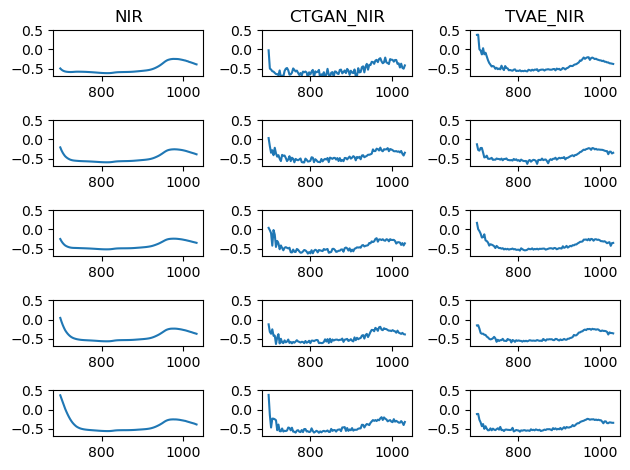

In [149]:
plt.tight_layout()
plt.show()

We see that the synthetic data is much rougher. Some smoothing might be in order.

In [95]:
def plot_cos_scores(df, dfs, names):
    fig, ax = plt.subplots(1, len(dfs))
    for idx, df_ in enumerate(dfs):
        scores = []
        for col in df.columns:
            scores.append(cosine_similarity(df.loc[:, col], df_.loc[:, col]))
        ax[idx].plot(scores)
        ax[idx].set_title(names[idx])

    plt.show()

def plot_correlation_scores(df, dfs, names):
    """
    Function that plots the correlation between 
    """
    fig, ax = plt.subplots(1, len(dfs))
    for idx, df_ in enumerate(dfs):
        scores = []
        for col in df.columns:
            scores.append(df[col].corr(df_[col], method='spearman'))
        ax[idx].plot(scores)
        ax[idx].set_title(names[idx])
    plt.show()

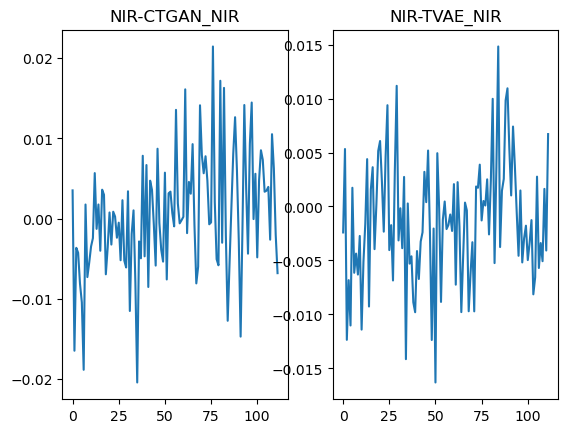

In [96]:
plot_correlation_scores(nir, [ctgan_nir, tvae_nir], ["NIR-CTGAN_NIR", "NIR-TVAE_NIR"])

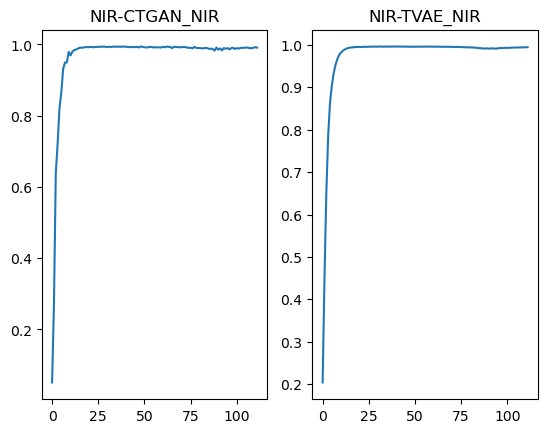

In [97]:
plot_cos_scores(nir, [ctgan_nir, tvae_nir], ["NIR-CTGAN_NIR", "NIR-TVAE_NIR"])

In [98]:
nir.corr()

,699,702,705,708,711,714,717,720,723,726,...,1005,1008,1011,1014,1017,1020,1023,1026,1029,1032
699,1.000000,0.998391,0.994501,0.989192,0.982795,0.976554,0.969360,0.960745,0.949676,0.935347,...,0.519921,0.526927,0.533891,0.540752,0.547145,0.552724,0.557081,0.561106,0.564754,0.567761
702,0.998391,1.000000,0.998825,0.995830,0.991404,0.986586,0.980588,0.972954,0.962666,0.948885,...,0.517580,0.525021,0.532375,0.539628,0.546334,0.552163,0.556780,0.561001,0.564808,0.567979
705,0.994501,0.998825,1.000000,0.999064,0.996462,0.993017,0.988236,0.981675,0.972335,0.959345,...,0.516965,0.524848,0.532614,0.540275,0.547318,0.553422,0.558317,0.562760,0.566758,0.570119
708,0.989192,0.995830,0.999064,1.000000,0.999139,0.997069,0.993577,0.988229,0.980066,0.968175,...,0.519020,0.527361,0.535576,0.543678,0.551092,0.557504,0.562705,0.567404,0.571634,0.575218
711,0.982795,0.991404,0.996462,0.999139,1.000000,0.999364,0.997301,0.993386,0.986722,0.976346,...,0.525101,0.533924,0.542640,0.551229,0.559059,0.565817,0.571363,0.576361,0.580870,0.584717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.552724,0.552163,0.553422,0.557504,0.565817,0.575989,0.589650,0.606784,0.628149,0.652740,...,0.982108,0.988150,0.992940,0.996207,0.998534,1.000000,0.998802,0.996967,0.994817,0.992049
1023,0.557081,0.556780,0.558317,0.562705,0.571363,0.581905,0.595985,0.613599,0.635473,0.660612,...,0.975770,0.983190,0.989203,0.993598,0.996615,0.998802,1.000000,0.999019,0.997114,0.995126
1026,0.561106,0.561001,0.562760,0.567404,0.576361,0.587240,0.601714,0.619785,0.642155,0.667834,...,0.969035,0.977363,0.984740,0.990287,0.994303,0.996967,0.999019,1.000000,0.999079,0.997194
1029,0.564754,0.564808,0.566758,0.571634,0.580870,0.592070,0.606922,0.625435,0.648289,0.674501,...,0.961842,0.970943,0.979292,0.986169,0.991228,0.994817,0.997114,0.999079,1.000000,0.999110


In [99]:
nir_vec = np.array(nir.corr()).flatten()
ctgan_vec = np.array(ctgan_nir.corr()).flatten()
tvae_vec = np.array(tvae_nir.corr()).flatten()
cos_similarity(nir_vec, tvae_vec)

0.9859885256822485

In [100]:
spec_corr = pd.DataFrame(columns=["CTGAN NIR", "TVAE NIR"], index=nir.columns)

# Kolmogorov-Smirnov test

In [101]:
mannwhitneyu(nir.iloc[:, 1], ctgan_nir.iloc[:,1])

MannwhitneyuResult(statistic=50141217.5, pvalue=2.133225184180384e-272)

In [102]:
from scipy.stats import kstest, ttest_ind, mannwhitneyu

# list for storing kstest scores
kstest_scores_ctgan = []
kstest_scores_tvae = []

# list for storing t-test scores
ttest_scores_ctgan = []
ttest_scores_tvae = []

# list for storing U mann whitney scores
mwu_scores_ctgan = []
mwu_scores_tvae = []

for col in nir.columns:

    # t-test
    ttest_scores_ctgan.append(ttest_ind(nir.loc[:, col], ctgan_nir.loc[:, col])[1])
    ttest_scores_tvae.append(ttest_ind(nir.loc[:, col], tvae_nir.loc[:, col])[1])

    # Mann Whitney U-test
    mwu_scores_ctgan.append(mannwhitneyu(nir.loc[:, col], ctgan_nir.loc[:, col])[1])
    mwu_scores_tvae.append(mannwhitneyu(nir.loc[:, col], tvae_nir.loc[:, col])[1])

    # kolmogorov-smirnov
    kstest_scores_ctgan.append(kstest(nir.loc[:, col], ctgan_nir.loc[:,col])[1])
    kstest_scores_tvae.append(kstest(nir.loc[:, col], tvae_nir.loc[:,col])[1])
    

In [103]:
kstest_mean_ctgan = np.round(np.mean(kstest_scores_ctgan),3)
kstest_mean_tvae = np.round(np.mean(kstest_scores_tvae),3)

ttest_mean_ctgan = np.round(np.mean(ttest_scores_ctgan),3)
ttest_mean_tvae = np.round(np.mean(ttest_scores_tvae),3)

mwu_mean_ctgan = np.round(np.mean(mwu_scores_ctgan), 3)
mwu_mean_tvae = np.round(np.mean(mwu_scores_tvae), 3)

uni_tests = pd.DataFrame(columns=["CTGAN_NIR", "TVAE_NIR"], index=["Kolmogorov-Smirnov", "Student T", "Mann Whitney U"])
uni_tests["CTGAN_NIR"] = [kstest_mean_ctgan, ttest_mean_ctgan, mwu_mean_ctgan]
uni_tests["TVAE_NIR"] = [kstest_mean_tvae, ttest_mean_tvae, mwu_mean_tvae]



In [104]:
uni_tests

,CTGAN_NIR,TVAE_NIR
Kolmogorov-Smirnov,0.000,0.013
Student T,0.020,0.111
Mann Whitney U,0.011,0.148


In [209]:
# CTGAN
mwu_perc_ctgan = np.round(sum(p>0.05 for p in mwu_scores_ctgan)/len(mwu_scores_ctgan)*100, 3)
kstest_perc_ctgan = np.round(sum(p>0.05 for p in kstest_scores_ctgan)/len(mwu_scores_ctgan)*100, 3)
ttest_perc_ctgan = np.round(sum(p>0.05 for p in ttest_scores_ctgan)/len(mwu_scores_ctgan)*100, 3)

# TVAE
mwu_perc_tvae = np.round(sum(p>0.05 for p in mwu_scores_tvae)/len(mwu_scores_ctgan)*100, 3)
kstest_perc_tvae = np.round(sum(p>0.05 for p in kstest_scores_tvae)/len(mwu_scores_ctgan)*100, 3)
ttest_perc_tvae = np.round(sum(p>0.05 for p in ttest_scores_tvae)/len(mwu_scores_ctgan)*100, 3)



In [210]:
uni_tests_perc = pd.DataFrame(columns=["CTGAN_NIR", "TVAE_NIR"], index=["Kolmogorov-Smirnov", "Student T", "Mann Whitney U"])
uni_tests_perc["CTGAN_NIR"] = [kstest_perc_ctgan, ttest_perc_ctgan, mwu_perc_ctgan]
uni_tests_perc["TVAE_NIR"] = [kstest_perc_tvae, ttest_perc_tvae, mwu_perc_tvae]


In [211]:
uni_tests_perc

,CTGAN_NIR,TVAE_NIR
Kolmogorov-Smirnov,0.000,9.821
Student T,3.571,33.929
Mann Whitney U,1.786,27.679


In [105]:
ctgan_tests_df = pd.DataFrame(columns=["Student T", "Mann Whitney U", "Kolmogorov-Smirnov"], index=nir.columns)
tvae_tests_df = pd.DataFrame(columns=["Student T", "Mann Whitney U", "Kolmogorov-Smirnov"], index=nir.columns)

ctgan_tests_df.loc[:,"Student T"] = ttest_scores_ctgan
ctgan_tests_df.loc[:,"Mann Whitney U"] = mwu_scores_ctgan
ctgan_tests_df.loc[:,"Kolmogorov-Smirnov"] = kstest_scores_ctgan

tvae_tests_df.loc[:, "Student T"] = ttest_scores_tvae
tvae_tests_df.loc[:, "Mann Whitney U"] = mwu_scores_tvae
tvae_tests_df.loc[:, "Kolmogorov-Smirnov"] = kstest_scores_tvae

# Reset the index to create a 'Wavelength' column
ctgan_tests_df = ctgan_tests_df.reset_index().rename(columns={'index': 'Wavelength'})
tvae_tests_df = tvae_tests_df.reset_index().rename(columns={'index': 'Wavelength'})

# Convert the 'Wavelength' column to integers
ctgan_tests_df['Wavelength'] = ctgan_tests_df['Wavelength'].astype(int)
tvae_tests_df['Wavelength'] = tvae_tests_df['Wavelength'].astype(int)

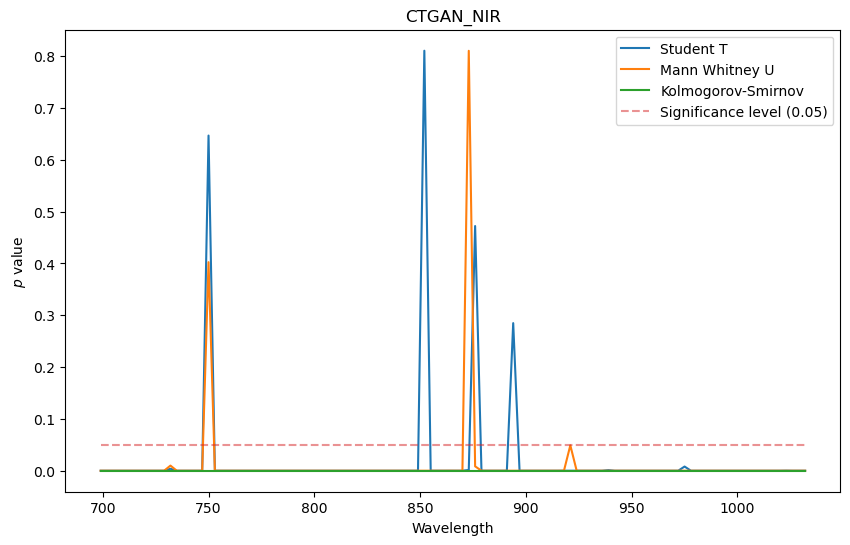

In [218]:
# Plot ctgan_nir using Seaborn lineplots
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='Wavelength', y='Student T', data=ctgan_tests_df, label='Student T')
sns.lineplot(x='Wavelength', y='Mann Whitney U', data=ctgan_tests_df, label='Mann Whitney U')
sns.lineplot(x='Wavelength', y='Kolmogorov-Smirnov', data=ctgan_tests_df, label='Kolmogorov-Smirnov')
sns.lineplot(x='Wavelength', y=0.05, data=ctgan_tests_df, label='Significance level (0.05)', linestyle='--', alpha=0.5)

#plt.axhline(y=0.05, color='red', linestyle='--')
plt.ylabel("$\it{p}$ value")
plt.title("CTGAN_NIR")
plt.legend()
plt.show()

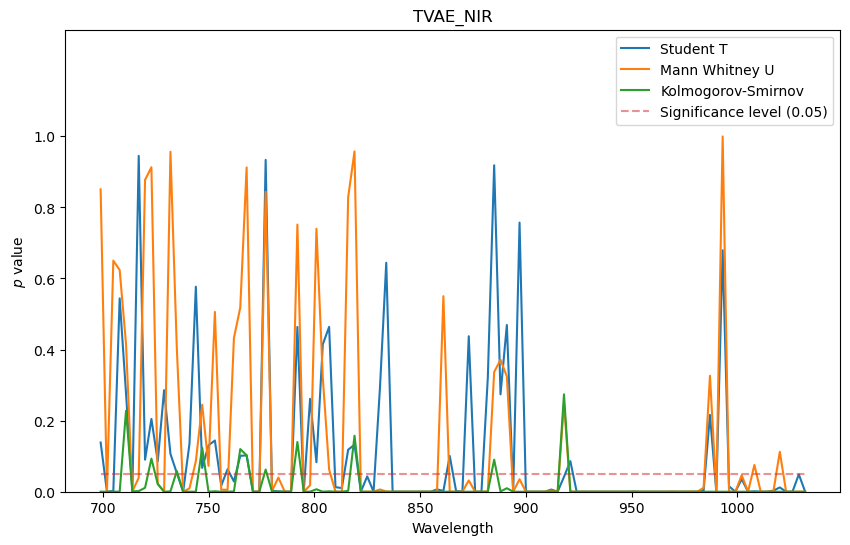

In [219]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x='Wavelength', y='Student T', data=tvae_tests_df, label='Student T')
sns.lineplot(x='Wavelength', y='Mann Whitney U', data=tvae_tests_df, label='Mann Whitney U')
sns.lineplot(x='Wavelength', y='Kolmogorov-Smirnov', data=tvae_tests_df, label='Kolmogorov-Smirnov')
sns.lineplot(x='Wavelength', y=0.05, data=tvae_tests_df, label='Significance level (0.05)', linestyle='--', alpha=0.5)


#plt.axhline(y=0.05, color='red', linestyle='--')
plt.ylim((0, 1.3))
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylabel("$\it{p}$ value")
plt.title("TVAE_NIR")
plt.legend(loc="best")
plt.show()

In [222]:
nir_response_corr = nir_response.corr()["DM"][:-1]
ctgan_response_corr = ctgan_nir_response.corr()["DM"][:-1]
tvae_response_corr = tvae_nir_response.corr()["DM"][:-1]

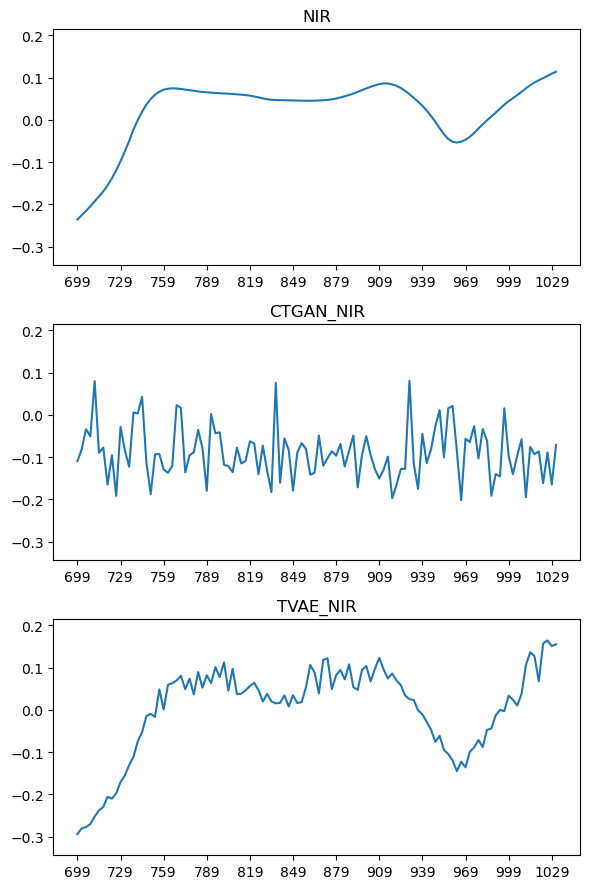

In [224]:
fig, ax = plt.subplots(3,1, figsize=(6,9))

y_min, y_max = min(nir_response_corr.min(), ctgan_response_corr.min(), tvae_response_corr.min())-0.05, max(nir_response_corr.max(), ctgan_response_corr.max(), tvae_response_corr.max())+0.05
#y_min, y_max = min(nir_response_corr[:, 1].min(), ctgan_response_corr[:, 1].min(), tvae_response_corr[:, 1].min())-3, max(nir_response_corr[:, 1].max(), ctgan_response_corr[:, 1].max(), tvae_response_corr[:, 1].max())+3

ax[0].plot(nir_response.corr()["DM"][:-1])
ax[0].set_xticks(nir_response.columns[::10])
ax[0].set_ylim(y_min, y_max)
ax[0].set_title("NIR")

ax[1].plot(ctgan_nir_response.corr()["DM"][:-1])
ax[1].set_xticks(nir_response.columns[::10])
ax[1].set_ylim(y_min, y_max)
ax[1].set_title("CTGAN_NIR")

ax[2].plot(tvae_nir_response.corr()["DM"][:-1])
ax[2].set_xticks(nir_response.columns[::10])
ax[2].set_ylim(y_min, y_max)
ax[2].set_title("TVAE_NIR")

plt.tight_layout()
plt.show()

In [220]:
cos_sim_ctgan = np.round(cosine_similarity(nir_response.corr()["DM"][:-1], ctgan_nir_response.corr()["DM"][:-1]), 3)
cos_sim_tvae = np.round(cosine_similarity(nir_response.corr()["DM"][:-1], tvae_nir_response.corr()["DM"][:-1]), 3)
# Creating dataframe that contains results
cos_sim_corr_target = pd.DataFrame([[cos_sim_ctgan, cos_sim_tvae]], columns=["CTGAN_NIR", "TVAE_NIR"], index=["Cos sim"])

In [221]:
cos_sim_corr_target

,CTGAN_NIR,TVAE_NIR
Cos sim,-0.336,0.92


In [109]:
# normalizing data before PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
nir_sc = pd.DataFrame(scaler.fit_transform(nir), columns=nir.columns)
ctgan_sc = pd.DataFrame(scaler.fit_transform(ctgan_nir), columns=ctgan_nir.columns)
tvae_sc = pd.DataFrame(scaler.fit_transform(tvae_nir), columns=tvae_nir.columns)

# Principal Component Analysis
pca = PCA(n_components=0.95)
pca_nir = pca.fit_transform(nir_sc)
pca_nir_variance = pca.explained_variance_
pca_nir_variance_ratio = pca.explained_variance_ratio_
nir_comp = pca.components_
pca_ctgan = pca.fit_transform(ctgan_sc)
pca_ctgan_variance = pca.explained_variance_
pca_ctgan_variance_ratio = pca.explained_variance_ratio_
ctgan_comp = pca.components_
pca_tvae = pca.fit_transform(tvae_sc)
pca_tvae_variance = pca.explained_variance_
pca_tvae_variance_ratio = pca.explained_variance_ratio_
tvae_comp = pca.components_

print(pca_nir.shape)
print(pca_ctgan.shape)
print(pca_tvae.shape)


(11691, 3)
(11691, 84)
(11691, 87)


In [110]:
nir_dm

1740     20.018622
1253     13.684495
689      18.211515
4281     13.431410
4330     17.453680
           ...    
7813     17.711203
10955    17.616802
905      13.429351
5192     15.015020
235      13.551136
Name: DM, Length: 11691, dtype: float64

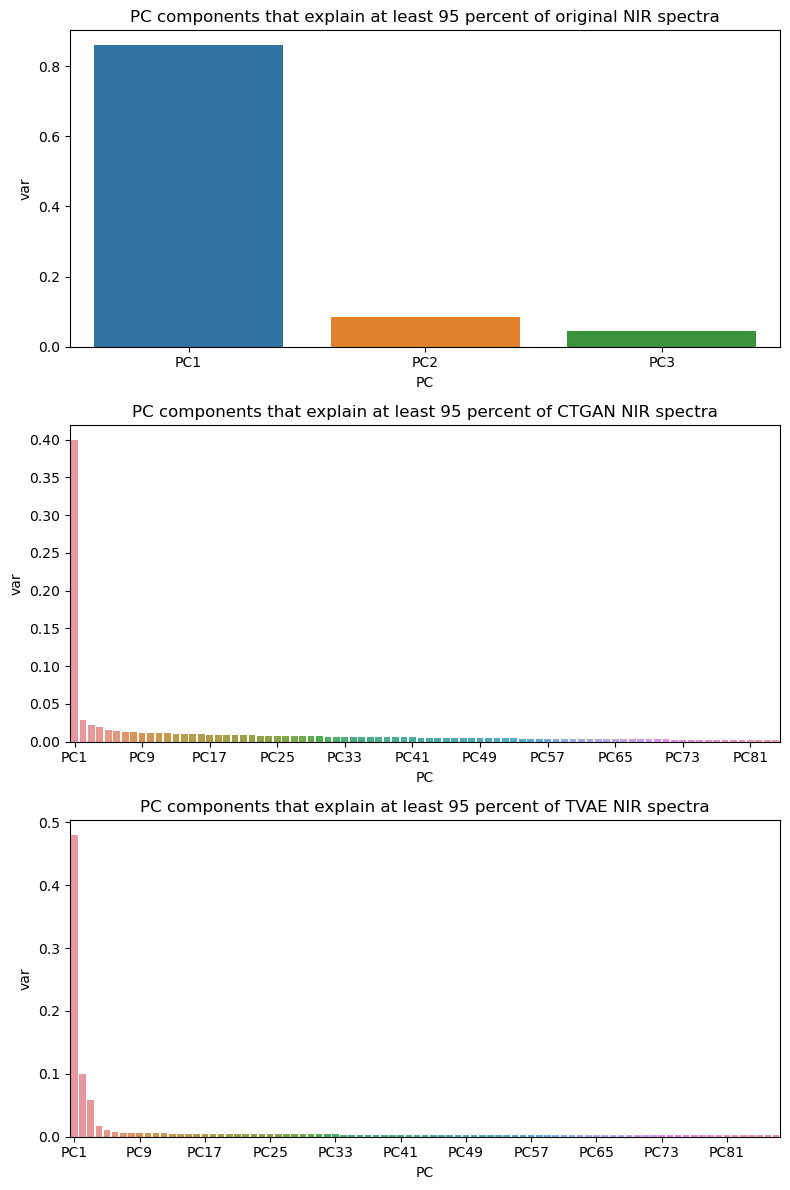

In [112]:
# Scree plots
# Creating dataframes in preparation for scree plots
nirScree = pd.DataFrame({'var':pca_nir_variance_ratio, 'PC':[f"PC{i+1}" for i, _ in enumerate(pca_nir_variance_ratio)]})
ctganScree = pd.DataFrame({'var':pca_ctgan_variance_ratio, 'PC':[f"PC{i+1}" for i, _ in enumerate(pca_ctgan_variance_ratio)]})
tvaeScree = pd.DataFrame({'var':pca_tvae_variance_ratio, 'PC':[f"PC{i+1}" for i, _ in enumerate(pca_tvae_variance_ratio)]})

# Plotting scree plots
fig, ax = plt.subplots(3, 1, figsize=(8,12))

sns.barplot(x='PC', y='var', data=nirScree, ax=ax[0]).set_title('PC components that explain at least 95 percent of original NIR spectra')
sns.barplot(x='PC', y='var', data=ctganScree, ax=ax[1]).set_title('PC components that explain at least 95 percent of CTGAN NIR spectra')
ax[1].set_xticks(ctganScree['PC'].index.tolist()[::8])
sns.barplot(x='PC', y='var', data=tvaeScree, ax=ax[2]).set_title('PC components that explain at least 95 percent of TVAE NIR spectra')
ax[2].set_xticks(tvaeScree['PC'].index.tolist()[::8])

plt.tight_layout()
plt.show()

In [229]:
def plot_scatter_pca(data1, data2, data3, title, subtitle1, subtitle2, subtitle3):
    fig, ax = plt.subplots(2,2, figsize=(12, 8))
    
    x_min, x_max = min(data1[:, 0].min(), data2[:, 0].min(), data3[:, 0].min())-3, max(data1[:, 0].max(), data2[:, 0].max(), data3[:, 0].max())+3
    y_min, y_max = min(data1[:, 1].min(), data2[:, 1].min(), data3[:, 1].min())-3, max(data1[:, 1].max(), data2[:, 1].max(), data3[:, 1].max())+3
    
    ax[0, 0].scatter(data1[:, 0], data1[:, 1])
    ax[0, 0].set_title(subtitle1)
    ax[0, 0].set_xlim(x_min, x_max)
    ax[0, 0].set_ylim(y_min, y_max)
    ax[0, 0].set_xlabel("PC1")
    ax[0, 0].set_ylabel("PC2")
    
    ax[0, 1].scatter(data2[:, 0], data2[:, 1])
    ax[0, 1].set_title(subtitle2)
    ax[0, 1].set_xlim(x_min, x_max)
    ax[0, 1].set_ylim(y_min, y_max)
    ax[0, 1].set_xlabel("PC1")
    ax[0, 1].set_ylabel("PC2")
    
    ax[1, 0].scatter(data1[:, 0], data1[:, 1])
    ax[1, 0].set_title(subtitle1)
    ax[1, 0].set_xlim(x_min, x_max)
    ax[1, 0].set_ylim(y_min, y_max)
    ax[1, 0].set_xlabel("PC1")
    ax[1, 0].set_ylabel("PC2")

    ax[1, 1].scatter(data3[:, 0], data3[:, 1])
    ax[1, 1].set_title(subtitle3)
    ax[1, 1].set_xlim(x_min, x_max)
    ax[1, 1].set_ylim(y_min, y_max)
    ax[1, 1].set_xlabel("PC1")
    ax[1, 1].set_ylabel("PC2")
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


In [231]:
def plot_scatter_iso(data1, data2, data3, title, subtitle1, subtitle2, subtitle3):
    fig, ax = plt.subplots(2,2, figsize=(12, 8))
    
    x_min, x_max = min(data1[:, 0].min(), data2[:, 0].min(), data3[:, 0].min())-3, max(data1[:, 0].max(), data2[:, 0].max(), data3[:, 0].max())+3
    y_min, y_max = min(data1[:, 1].min(), data2[:, 1].min(), data3[:, 1].min())-3, max(data1[:, 1].max(), data2[:, 1].max(), data3[:, 1].max())+3
    
    ax[0, 0].scatter(data1[:, 0], data1[:, 1])
    ax[0, 0].set_title(subtitle1)
    ax[0, 0].set_xlim(x_min, x_max)
    ax[0, 0].set_ylim(y_min, y_max)
    ax[0, 0].set_xlabel("LDE1")
    ax[0, 0].set_ylabel("LDE2")
    
    ax[0, 1].scatter(data2[:, 0], data2[:, 1])
    ax[0, 1].set_title(subtitle2)
    ax[0, 1].set_xlim(x_min, x_max)
    ax[0, 1].set_ylim(y_min, y_max)
    ax[0, 1].set_xlabel("LDE1")
    ax[0, 1].set_ylabel("LDE2")
    
    ax[1, 0].scatter(data1[:, 0], data1[:, 1])
    ax[1, 0].set_title(subtitle1)
    ax[1, 0].set_xlim(x_min, x_max)
    ax[1, 0].set_ylim(y_min, y_max)
    ax[1, 0].set_xlabel("LDE1")
    ax[1, 0].set_ylabel("LDE2")

    ax[1, 1].scatter(data3[:, 0], data3[:, 1])
    ax[1, 1].set_title(subtitle3)
    ax[1, 1].set_xlim(x_min, x_max)
    ax[1, 1].set_ylim(y_min, y_max)
    ax[1, 1].set_xlabel("LDE1")
    ax[1, 1].set_ylabel("LDE2")
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


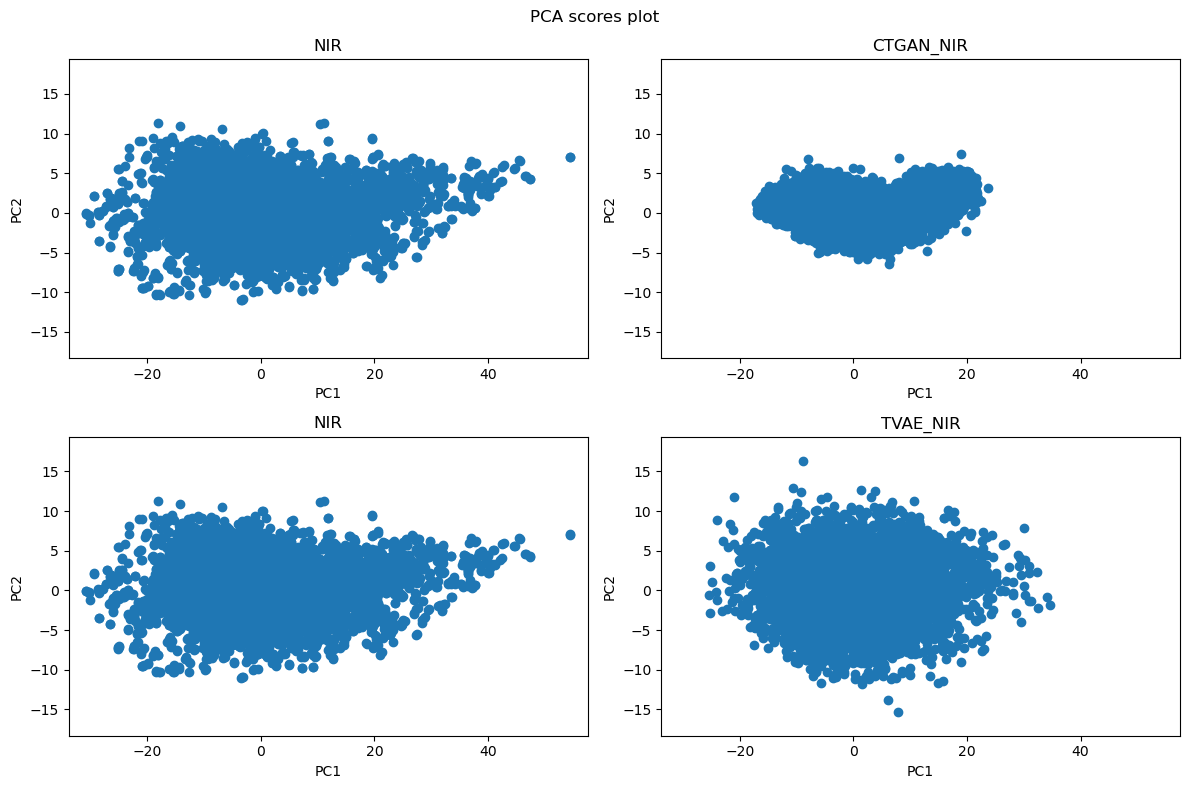

In [232]:
plot_scatter_pca(pca_nir, pca_ctgan, pca_tvae, "PCA scores plot", subtitle1="NIR", subtitle2="CTGAN_NIR", subtitle3="TVAE_NIR")

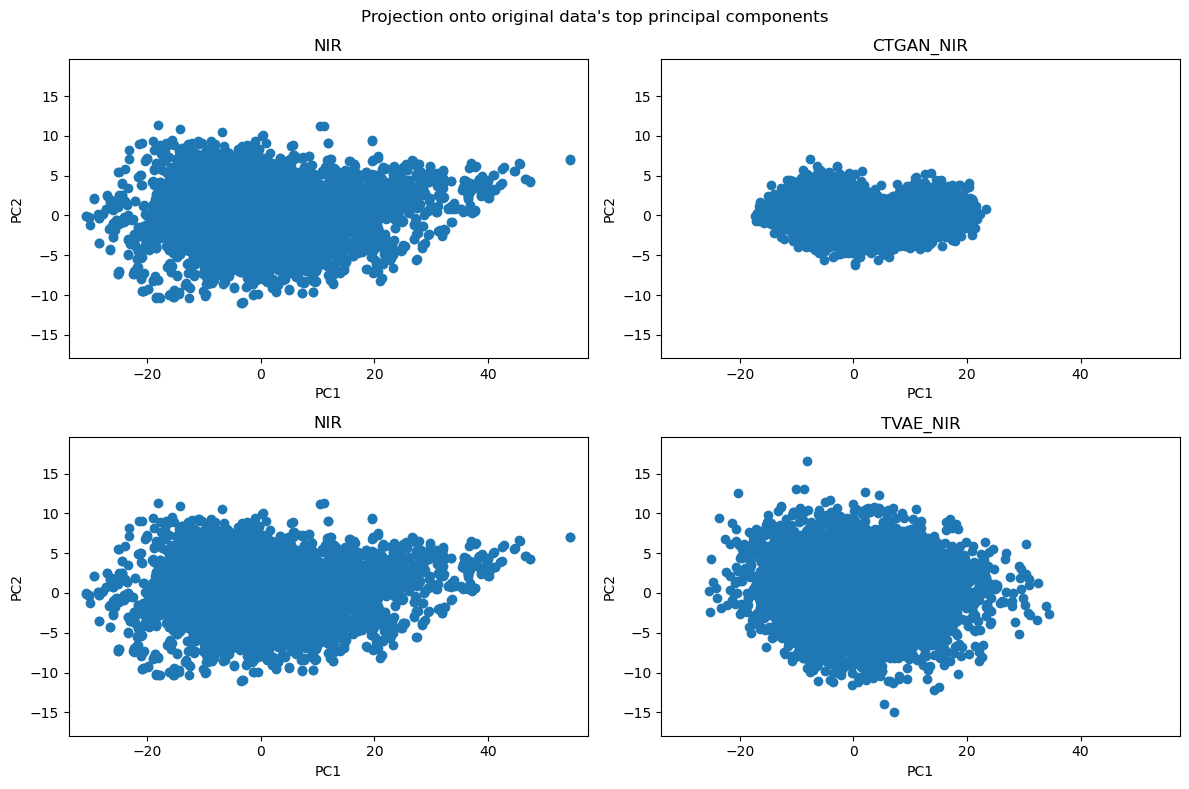

In [233]:
pca = PCA(n_components=2)
pca_nir = pca.fit_transform(nir_sc)
pca_ctgan_nir = pca.transform(ctgan_sc)
pca_tvae_nir = pca.transform(tvae_sc)

plot_scatter_pca(pca_nir, pca_ctgan_nir, pca_tvae_nir, "Projection onto original data's top principal components", subtitle1="NIR", subtitle2="CTGAN_NIR", subtitle3="TVAE_NIR")

In [115]:
from sklearn.manifold import Isomap
isomap_nir = Isomap(n_components=2).fit_transform(nir_sc)
isomap_ctgan = Isomap(n_components=2).fit_transform(ctgan_sc)
isomap_tvae = Isomap(n_components=2).fit_transform(tvae_sc)

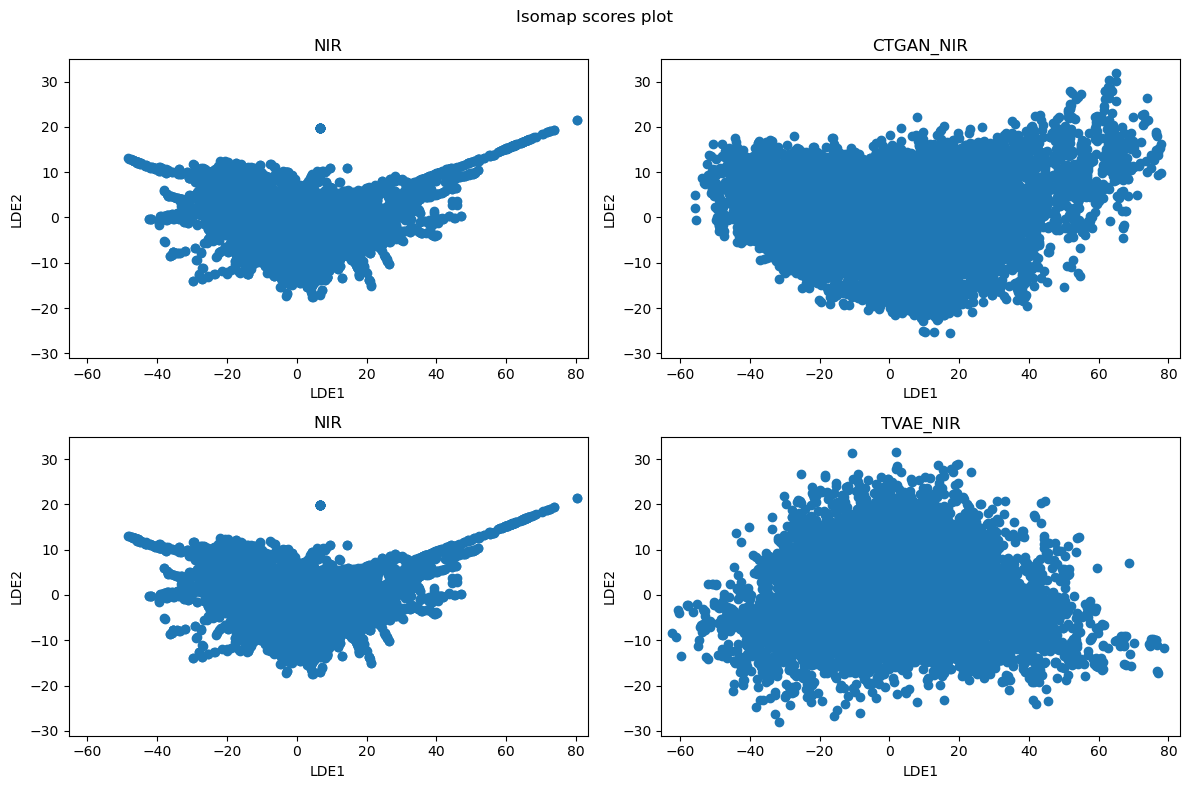

In [234]:
plot_scatter_iso(isomap_nir, isomap_ctgan, isomap_tvae, "Isomap scores plot", subtitle1="NIR", subtitle2="CTGAN_NIR", subtitle3="TVAE_NIR")

In [179]:
isomap = Isomap(n_components=2)
isomap.fit_transform(nir)
isomap_ctgan_nir = isomap.transform(ctgan_sc)
isomap_tvae_nir = isomap.transform(tvae_sc)

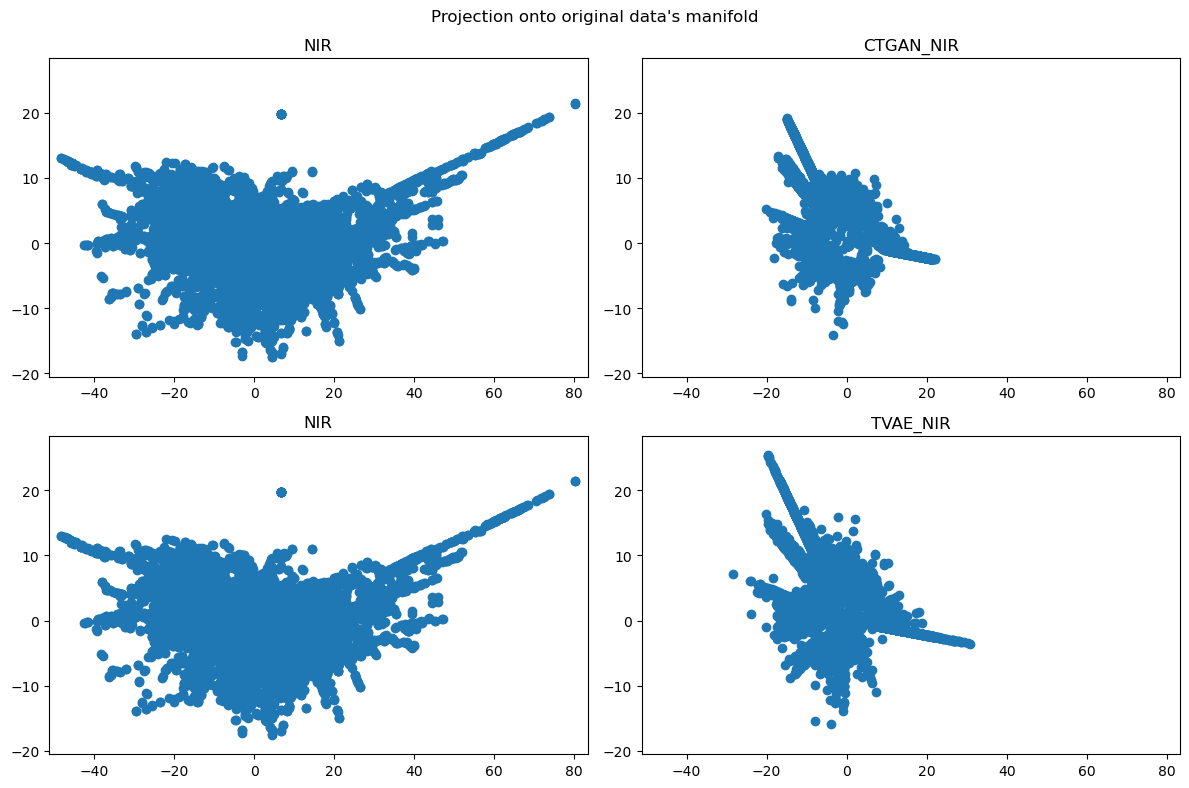

In [235]:
plot_scatter(isomap_nir, isomap_ctgan_nir, isomap_tvae_nir, "Projection onto original data's manifold", subtitle1="NIR", subtitle2="CTGAN_NIR", subtitle3="TVAE_NIR")

# Data Labeling Analysis

In [117]:
# creating copies of data
nir_label = nir.copy()
ctgan_label = ctgan_nir.copy()
tvae_label = tvae_nir.copy()

# labeling data
nir_label['label'] = 0
ctgan_label['label'] = 1
tvae_label['label'] = 1

# Concatenating the dataframes
ctgan_label = pd.concat([nir_label, ctgan_label])
tvae_label = pd.concat([nir_label, tvae_label])

# Resetting index of data
ctgan_label.reset_index(inplace=True)
tvae_label.reset_index(inplace=True)

# Permuting the rows
ctgan_label = ctgan_label.reindex(np.random.RandomState(seed=1).permutation(ctgan_label.index))
tvae_label = tvae_label.reindex(np.random.RandomState(seed=1).permutation(tvae_label.index))

# Separating labels from data
X_ctgan = ctgan_label
y_ctgan = X_ctgan.pop('label')

X_tvae = tvae_label
y_tvae = X_tvae.pop('label')

# Splitting the X and y into train and test sets
X_train_ctgan, X_test_ctgan, y_train_ctgan, y_test_ctgan = train_test_split(X_ctgan, y_ctgan, test_size=0.1, stratify=y_ctgan, random_state=1)

X_train_tvae, X_test_tvae, y_train_tvae, y_test_tvae = train_test_split(X_tvae, y_tvae, test_size=0.1, stratify=y_ctgan, random_state=1)

# Scaling data
sc_ctgan = StandardScaler()
sc_tvae = StandardScaler()

# Scaling CTGAN
X_train_ctgan_sc = sc_ctgan.fit_transform(X_train_ctgan)
X_test_ctgan_sc = sc_ctgan.transform(X_test_ctgan)

# Scaling TVAE
X_train_tvae_sc = sc_tvae.fit_transform(X_train_tvae)
X_test_tvae_sc = sc_tvae.transform(X_test_tvae)


### Random Forest

In [118]:
forest_ctgan = RandomForestClassifier(n_estimators=100, random_state=9, n_jobs=-1)
forest_ctgan.fit(X_train_ctgan_sc, y_train_ctgan)
forest_ctgan_pred = forest_ctgan.predict(X_test_ctgan_sc)

In [119]:
forest_tvae = RandomForestClassifier(n_estimators=100, random_state=9, n_jobs=-1)
forest_tvae.fit(X_train_tvae_sc, y_train_tvae)
forest_tvae_pred = forest_tvae.predict(X_test_tvae_sc)

### KNN

In [120]:
from sklearn.neighbors import KNeighborsClassifier
KNN_ctgan = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
KNN_ctgan.fit(X_train_ctgan_sc, y_train_ctgan)
KNN_ctgan_pred = KNN_ctgan.predict(X_test_ctgan_sc)

In [121]:
KNN_tvae = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
KNN_tvae.fit(X_train_tvae_sc, y_train_tvae)
KNN_tvae_pred = KNN_tvae.predict(X_test_tvae_sc)

### Decision Tree

In [122]:
from sklearn.tree import DecisionTreeClassifier
tree_ctgan = DecisionTreeClassifier(random_state=9)
tree_ctgan.fit(X_train_ctgan_sc, y_train_ctgan)
tree_ctgan_pred = tree_ctgan.predict(X_test_ctgan_sc)

In [123]:
tree_tvae = DecisionTreeClassifier(random_state=9)
tree_tvae.fit(X_train_tvae_sc, y_train_tvae)
tree_tvae_pred = tree_tvae.predict(X_test_tvae_sc)

### SVM

In [124]:
from sklearn.svm import SVC 
svc_ctgan = SVC(C=100, max_iter=300, kernel='linear', probability=True, random_state=9)
svc_ctgan.fit(X_train_ctgan_sc,y_train_ctgan)
svc_ctgan_pred = svc_ctgan.predict(X_test_ctgan_sc)

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


In [125]:
svc_tvae = SVC(C=100, max_iter=300, kernel='linear', probability=True, random_state=9)
svc_tvae.fit(X_train_tvae_sc,y_train_tvae)
svc_tvae_pred = svc_tvae.predict(X_test_tvae_sc)

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


### MLP

In [126]:
from sklearn.neural_network import MLPClassifier

# Instantiate the MLPClassifier with the given parameters
mlp_ctgan = MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                    max_iter=300,
                    random_state=9)

mlp_ctgan.fit(X_train_ctgan_sc, y_train_ctgan)
mlp_ctgan_pred = mlp_ctgan.predict(X_test_ctgan_sc)

In [127]:
mlp_tvae = MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                    max_iter=300,
                    random_state=9)

mlp_tvae.fit(X_train_tvae_sc, y_train_tvae)
mlp_tvae_pred = mlp_tvae.predict(X_test_tvae_sc)

#### Scoring and creating a score table for CTGAN and TVAE

In [128]:
# CTGAN
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

ctgan_scores = pd.DataFrame(columns=["Accuracy", "F1", "Precision","Recall"],index=["RF", "KNN", "DT", "SVM", "MLP"])
ctgan_scores.loc["RF", :] = [accuracy_score(forest_ctgan_pred, y_test_ctgan), f1_score(forest_ctgan_pred, y_test_ctgan), precision_score(forest_ctgan_pred, y_test_ctgan), recall_score(forest_ctgan_pred, y_test_ctgan)]
ctgan_scores.loc["KNN", :] = [accuracy_score(KNN_ctgan_pred, y_test_ctgan), f1_score(KNN_ctgan_pred, y_test_ctgan), precision_score(KNN_ctgan_pred, y_test_ctgan), recall_score(KNN_ctgan_pred, y_test_ctgan)]
ctgan_scores.loc["DT", :] = [accuracy_score(tree_ctgan_pred, y_test_ctgan), f1_score(tree_ctgan_pred, y_test_ctgan), precision_score(tree_ctgan_pred, y_test_ctgan), recall_score(tree_ctgan_pred, y_test_ctgan)]
ctgan_scores.loc["SVM", :] = [accuracy_score(svc_ctgan_pred, y_test_ctgan), f1_score(svc_ctgan_pred, y_test_ctgan), precision_score(svc_ctgan_pred, y_test_ctgan), recall_score(svc_ctgan_pred, y_test_ctgan)]
ctgan_scores.loc["MLP", :] = [accuracy_score(mlp_ctgan_pred, y_test_ctgan), f1_score(mlp_ctgan_pred, y_test_ctgan), precision_score(mlp_ctgan_pred, y_test_ctgan), recall_score(mlp_ctgan_pred, y_test_ctgan)]





In [129]:
ctgan_scores

,Accuracy,F1,Precision,Recall
RF,1.0,1.0,1.0,1.0
KNN,0.760154,0.684654,0.520513,1.0
DT,0.99658,0.996581,0.996581,0.996581
SVM,0.999145,0.999145,0.998291,1.0
MLP,1.0,1.0,1.0,1.0


In [130]:
# TVAE

tvae_scores = pd.DataFrame(columns=["Accuracy", "F1", "Precision","Recall"],index=["RF", "KNN", "DT", "SVM", "MLP"])
tvae_scores.loc["RF", :] = [accuracy_score(forest_tvae_pred, y_test_tvae), f1_score(forest_tvae_pred, y_test_tvae), precision_score(forest_tvae_pred, y_test_tvae), recall_score(forest_tvae_pred, y_test_tvae)]
tvae_scores.loc["KNN", :] = [accuracy_score(KNN_tvae_pred, y_test_tvae), f1_score(KNN_tvae_pred, y_test_tvae), precision_score(KNN_tvae_pred, y_test_tvae), recall_score(KNN_tvae_pred, y_test_tvae)]
tvae_scores.loc["DT", :] = [accuracy_score(tree_tvae_pred, y_test_tvae), f1_score(tree_tvae_pred, y_test_tvae), precision_score(tree_tvae_pred, y_test_tvae), recall_score(tree_tvae_pred, y_test_tvae)]
tvae_scores.loc["SVM", :] = [accuracy_score(svc_tvae_pred, y_test_tvae), f1_score(svc_tvae_pred, y_test_tvae), precision_score(svc_tvae_pred, y_test_tvae), recall_score(svc_tvae_pred, y_test_tvae)]
tvae_scores.loc["MLP", :] = [accuracy_score(mlp_tvae_pred, y_test_tvae), f1_score(mlp_tvae_pred, y_test_tvae), precision_score(mlp_tvae_pred, y_test_tvae), recall_score(mlp_tvae_pred, y_test_tvae)]


In [131]:
tvae_scores

,Accuracy,F1,Precision,Recall
RF,0.999572,0.999572,0.999145,1.0
KNN,0.501496,0.006814,0.003419,1.0
DT,0.969645,0.969251,0.95641,0.982441
SVM,0.501496,0.656857,0.953846,0.500898
MLP,1.0,1.0,1.0,1.0


## Utility

In [132]:
# Setting up datasets with response variable "DM"
nir_spec_train, nir_spec_test, nir_dm_train, nir_dm_test = train_test_split(nir, nir_dm, test_size=0.2, random_state=9)
tvae_spec_train, tvae_spec_test, tvae_dm_train, tvae_dm_test = train_test_split(tvae_nir, tvae_dm, test_size=0.2, random_state=9)
ctgan_spec_train, ctgan_spec_test, ctgan_dm_train, ctgan_dm_test = train_test_split(ctgan_nir, ctgan_dm, test_size=0.2, random_state=9)

# Scaling data
sc_nir = StandardScaler()
sc_ctgan = StandardScaler()
sc_tvae = StandardScaler()

nir_spec_train_sc = sc_nir.fit_transform(nir_spec_train)
nir_spec_test_sc = sc_nir.transform(nir_spec_test)

ctgan_spec_train_sc = sc_ctgan.fit_transform(ctgan_spec_train)
ctgan_spec_test_sc = sc_ctgan.transform(nir_spec_test)

tvae_spec_train_sc = sc_tvae.fit_transform(tvae_spec_train)
tvae_spec_test_sc = sc_tvae.transform(nir_spec_test)

In [133]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
def train_and_predict(rd, rd_y, sd, sd_y):

    rd_train, rd_test, rd_train_y, rd_test_y = train_test_split(rd, rd_y, test_size=0.2, random_state=9)
    sd_train, sd_test, sd_train_y, sd_test_y = train_test_split(sd, sd_y, test_size=0.2, random_state=9)

    rd_sc = StandardScaler()
    sd_sc = StandardScaler()

    rd_train_sc = rd_sc.fit_transform(rd_train)
    rd_test_sc = rd_sc.transform(rd_test)

    sd_train_sc = sd_sc.fit_transform(sd_train)
    sd_test_sc = sd_sc.transform(rd_test)

    results = {"Real":[], "Synthetic":[]}

    models = {"RF":RandomForestRegressor(n_estimators=100, random_state=9, n_jobs=-1), 
    "KNN":KNeighborsRegressor(n_neighbors=10, n_jobs=-1),
    "DT":DecisionTreeRegressor(random_state=9),
    "SVM":SVR(C=100, max_iter = 300, kernel = "linear"),
    "MLP":MLPRegressor(hidden_layer_sizes=(128, 64, 32), max_iter=300, random_state=9)}

    for name, model in models.items():
        model.fit(rd_train_sc, rd_train_y)
        results["Real"].append(model.score(rd_test_sc, rd_test_y))
        model.fit(sd_train_sc, sd_train_y)
        results["Synthetic"].append(model.score(sd_test_sc, rd_test_y))

    return results




In [134]:
results_ctgan = train_and_predict(nir, nir_dm, ctgan_nir, ctgan_dm)

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


In [135]:
utility_ctgan = pd.DataFrame(results_ctgan, index=["RF", "KNN", "DT", "SVM", "MLP"])
utility_ctgan

,Real,Synthetic
RF,0.667707,-0.006353
KNN,0.372196,-0.146006
DT,0.292846,-1.322496
SVM,-8.574527,-3.601274
MLP,0.708510,-1.269254


In [136]:
results_tvae = train_and_predict(nir, nir_dm, tvae_nir, tvae_dm)

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


In [137]:
utility_tvae = pd.DataFrame(results_tvae, index=["RF", "KNN", "DT", "SVM", "MLP"])
utility_tvae

,Real,Synthetic
RF,0.667707,0.180346
KNN,0.372196,0.133436
DT,0.292846,-0.255557
SVM,-8.574527,-2.544479
MLP,0.708510,0.002788


In [138]:
forest_rd = RandomForestRegressor()
forest_rd.fit(nir_spec_train, nir_dm_train)
forest_rd.score(nir_spec_test, nir_dm_test)

0.6743835138357451

In [139]:
forest_sd = RandomForestRegressor()
forest_sd.fit(tvae_spec_train, tvae_dm_train)
forest_sd.score(nir_spec_test, nir_dm_test)

0.1753387572180074

## Combining datasets (augmenting)

In [140]:
combined = pd.concat([nir_response.iloc[:8000, :], tvae_nir_response.iloc[:8000, :]])
test = nir_response.iloc[8000:, :]

combined_X, combined_y = combined.drop("DM", axis=1), combined["DM"]
test_X, test_y = test.drop("DM", axis=1), test["DM"]

In [141]:
forest_hd = RandomForestRegressor()
forest_hd.fit(combined_X, combined_y)
forest_hd.score(test_X, test_y)

0.6193386010639519

### Testing if RandomForest classifier can separate the two datasets

### Preparing the data for random forest classifier

In [142]:
nir2 = nir.drop("DM", axis=1)
synth_nir2 = synth_nir.drop("DM", axis=1)

nir2["target"] = 1
synth_nir2["target"] = 0

# Concatenating the two dataframes vertically on top of each other
nir_df = pd.concat([nir2, synth_nir2])

# resetting the index of nir_df
nir_df.reset_index(inplace=True)

# Permuting the rows of nir_df
nir_df = nir_df.reindex(np.random.RandomState(seed=1).permutation(nir_df.index))

# Splitting nir_df into features and target
X_nir2 = nir_df.iloc[:, :-1]
y_nir2 = nir_df.iloc[:, -1]

# Creating a train and test set
X_train_nir2, X_test_nir2, y_train_nir2, y_test_nir2 = train_test_split(X_nir2, 
y_nir2, test_size=0.2)


KeyError: "['DM'] not found in axis"

### Checking if random forest classifier is able to classify class correctly

In [ ]:
# Initializing a default instance of Random Forest classifier
classifier = RandomForestClassifier()

# Fitting classifier on train set
classifier.fit(X_train_nir2, y_train_nir2)

# Predicting on test set
classifier.score(X_test_nir2, y_test_nir2)

0.9978618772717553

Clearly, the machine learning algorithm have no problem in separating real from synthetic data

### Savgol filtering

In [ ]:
from scipy import signal
savgol_synth_nir = synth_nir.copy()
savgol_synth_nir.iloc[:, :-1] = signal.savgol_filter(savgol_synth_nir.iloc[:, :-1], window_length=9, polyorder=3)
savgol_synth_nir = pd.DataFrame(savgol_synth_nir, columns=nir.columns)

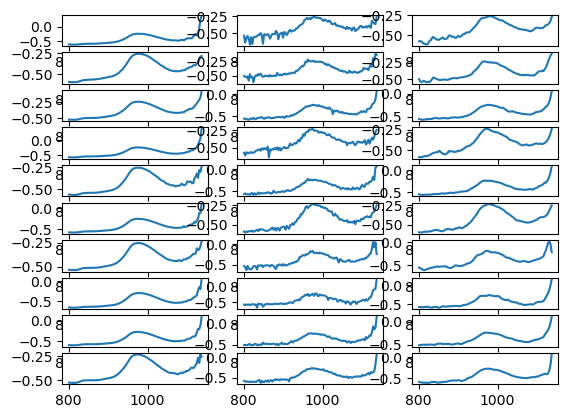

In [ ]:
plot_multiple_samples([nir.iloc[:, :-1], synth_nir.iloc[:, :-1], savgol_synth_nir.iloc[:, :-1]], list(range(10, 101, 10)))

In [ ]:
nir3 = nir.drop("DM", axis=1)
nir4 = nir3.copy()
synth_nir3 = savgol_synth_nir.drop("DM", axis=1)

nir3["target"] = 1
synth_nir3["target"] = 0

# Concatenating the two dataframes vertically on top of each other
nir_df3 = pd.concat([nir3, synth_nir3])

# resetting the index of nir_df
nir_df3.reset_index(inplace=True)

# Permuting the rows of nir_df
nir_df3 = nir_df3.reindex(np.random.RandomState(seed=1).permutation(nir_df3.index))

# Splitting nir_df into features and target
X_nir3 = nir_df3.iloc[:, :-1]
y_nir3 = nir_df3.iloc[:, -1]

# Creating a train and test set
X_train_nir3, X_test_nir3, y_train_nir3, y_test_nir3 = train_test_split(X_nir3, 
y_nir3, test_size=0.2)

In [ ]:
# Initializing a default instance of Random Forest classifier
classifier3 = RandomForestClassifier()

# Fitting classifier on train set
classifier3.fit(X_train_nir3, y_train_nir3)

# Predicting on test set
classifier3.score(X_test_nir3, y_test_nir3)

0.9875988881761814

The savitzky-golay filtering slightly improved the quality of the synthetic data

Repeating the experiment above with copy of data

In [ ]:
nir4 = nir3.copy()
nir4["target"] = 0

# Concatenating the two dataframes vertically on top of each other
nir_df4 = pd.concat([nir3, nir4])

# resetting the index of nir_df
nir_df4.reset_index(inplace=True)

# Permuting the rows of nir_df
nir_df4 = nir_df4.reindex(np.random.RandomState(seed=1).permutation(nir_df4.index))

# Splitting nir_df into features and target
X_nir4 = nir_df4.iloc[:, :-1]
y_nir4 = nir_df4.iloc[:, -1]

# Creating a train and test set
X_train_nir4, X_test_nir4, y_train_nir4, y_test_nir4 = train_test_split(X_nir4, 
y_nir4, test_size=0.2)

In [ ]:
# Initializing a default instance of Random Forest classifier
classifier4 = RandomForestClassifier()

# Fitting classifier on train set
classifier4.fit(X_train_nir4, y_train_nir4)

# Predicting on test set
classifier3.score(X_test_nir4, y_test_nir4)

0.5050245884113748

The classifier is clearly capable of distinguishing between real and synthetic data

### Machine learning utility

In [ ]:
regressor = RandomForestRegressor()

X = nir.iloc[:, :-1]
y = nir.iloc[:, -1]

X_synth = synth_nir.iloc[:, :-1]
y_synth = synth_nir.iloc[:, -1]

regressor.fit(X, y)

regressor.score(X_synth, y_synth)

0.12713229517410252

In [ ]:
regressor = RandomForestRegressor()

X = nir.iloc[:, :-1]
y = nir.iloc[:, -1]

X_synth = savgol_synth_nir.iloc[:, :-1]
y_synth = savgol_synth_nir.iloc[:, -1]

regressor.fit(X, y)

regressor.score(X_synth, y_synth)

0.10630742452033659

In [ ]:
regressor = RandomForestRegressor()

X = nir.iloc[:, :-1]
y = nir.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regressor.fit(X_train, y_train)

regressor.score(X_test, y_test)

0.515200290518522

### Augmenting data with synthetic data

In [ ]:
regressor = RandomForestRegressor()

nir_combined = pd.concat([nir, synth_nir.iloc[:2000, :]])

X = nir_combined.iloc[:, :-1]
y = nir_combined.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regressor.fit(X_train, y_train)

regressor.score(X_test, y_test)

0.48338064024312744